In [1]:
import os 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

# Random Forests

In [13]:
os.chdir("/Users/simonrdkn/Documents/commalla_acoustic_analysis/feature sets")
original_features = pd.read_csv("original feature extraction.csv")
sauter_features = pd.read_csv("sauter_feature_set.csv")
compare_2016 = pd.read_csv("commalla_compare_2016.csv")
gemaps_minimal = pd.read_csv("gemaps_minimal.csv")
gemaps_extended = pd.read_csv("gemaps_extended.csv")

results_table = pd.DataFrame({
    "dimension":[],
    "dataset":[],
    "technique":[],
    "r2":[],
    "MSE":[],
    "explained variance":[]
})

feature_importances = pd.DataFrame({
    "dimension":[],
    "dataset":[],
    "technique":[],
    "feature":[],
    "importance":[]
})

In [14]:
raw_datasets = [sauter_features, original_features, compare_2016, gemaps_minimal, gemaps_extended]
dataset_names = ["Sauter Features", "Custom Set", "ComPar-E 2016", "GeMAPS Minimal", "GeMAPS Extended"]

for dimension in ["mean_arousal", "mean_valence"]:
    for i in range(len(raw_datasets)):
        for run_j in range(100):
            dataset = raw_datasets[i].dropna()

            X = dataset[dataset.columns[7:]] # check columns if results are weird 
            y = dataset[dimension]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=run_j)
            scaler = StandardScaler() # scaling the data
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            rf = RandomForestRegressor(n_estimators=10, random_state=run_j) # formerly 100
            rf.fit(X_train, y_train)
            y_pred_test = rf.predict(X_test)

            new_row_stats = pd.DataFrame({
                "dimension":[dimension],
                "dataset":[dataset_names[i]],
                "technique":["Random Forest"], 
                "r2":[r2_score(y_test, y_pred_test)],
                "MSE":[mean_squared_error(y_test, y_pred_test)],
                "explained variance": [explained_variance_score(y_test, y_pred_test)]
                })
            results_table = pd.concat([results_table, new_row_stats])

            sort = rf.feature_importances_.argsort()[::-1][:10] # have to reverse order???
            for j in sort:
                new_row_importance = pd.DataFrame({
                    "dimension":[dimension],
                    "dataset":[dataset_names[i]],
                    "technique":["Random Forest"],  
                    "feature":[X.columns[j]],
                    "importance":[rf.feature_importances_[j]],
                    })
                feature_importances = pd.concat([feature_importances, new_row_importance])
                # print(new_row_importances)

In [10]:
for i in range(1): #range(len(raw_datasets)): 
    dataset = raw_datasets[i].dropna()
    X = dataset[dataset.columns[7:]]
    print(X.columns)
    print(dataset_names[i], len(X.columns))

Index(['duration', 'mean_pitch', 'min_pitch', 'max_pitch', 'stdev_pitch',
       'mean_intensity', 'spectral_cog', 'spectral_sd', 'amp_rms',
       'sd_intensity'],
      dtype='object')
Sauter Features 10


In [15]:
# Raw Results 
os.chdir("/Users/simonrdkn/Documents/commalla_acoustic_analysis/final results/random forest regression files")
results_table.to_csv("rf_results_100.csv")
feature_importances.to_csv("rf_importances_100.csv")

In [16]:
results_table_mean = results_table.groupby(by=["dimension", "dataset", "technique"], as_index=False).mean()
feature_importances_mean = feature_importances.groupby(by=["dimension", "dataset", "technique", "feature"], as_index=False).sum()
feature_importances_mean["importance"] = feature_importances_mean['importance'].div(100)

os.chdir("/Users/simonrdkn/Documents/commalla_acoustic_analysis/final results/random forest regression files")
results_table_mean.to_csv("rf_results_mean.csv")
feature_importances_mean.to_csv("rf_importances_mean.csv")


# ComPar-E Subsets 

Reusing code from "openSMILE parameters.ipynb"

In [17]:
compare_2016 = pd.read_csv("commalla_compare_2016.csv").dropna()

fband_cols = []
fband250_650_cols = []
fband1000_4000_cols = []

for param_name in compare_2016.columns:
    if "pcm_fftMag_fband" in param_name:
        fband_cols.append(param_name)
    if "pcm_fftMag_fband250-650" in param_name:
        fband250_650_cols.append(param_name)
    if "pcm_fftMag_fband1000-4000" in param_name:
        fband1000_4000_cols.append(param_name) 

param_set_list = [fband_cols, fband250_650_cols, fband1000_4000_cols]
param_set_names = ["pcm_fftMag_fband", "pcm_fftMag_fband250-650", "pcm_fftMag_fband1000-4000"]

subset_results = pd.DataFrame({
    "dimension":[],
    "dataset":[],
    "technique":[],
    "r2":[],
    "MSE":[],
    "explained variance":[]
})

subset_importances = pd.DataFrame({
    "dimension":[],
    "dataset":[],
    "technique":[],
    "feature":[],
    "importance":[]
})

In [18]:
def compare_2016_subset_rf(subset_index, df_1, df_2, run_number):
    i = subset_index # changing var names so I don't have to re-write the function 
    param_set_stats = df_1
    param_importances = df_2
    
    param_set = param_set_list[i]

    X = compare_2016[compare_2016.columns.intersection(param_set)]
    y = compare_2016["mean_arousal"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=run_number)

    rf = RandomForestRegressor(n_estimators=10, random_state=run_number) # reproducible random states
    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)

    new_row_stats = pd.DataFrame({
        "dimension":["mean_arousal"],
        "dataset":["ComPar-E 2016 "+param_set_names[i]],
        "technique":["Random Forest"],
        "r2":[r2_score(y_test, y_pred_test)],
        "MSE":[mean_squared_error(y_test, y_pred_test)],
        "explained variance": [explained_variance_score(y_test, y_pred_test)]
        })
    param_set_stats = pd.concat([param_set_stats, new_row_stats])
    
    sort = rf.feature_importances_.argsort()[::-1][:10] # have to reverse order???
    for j in sort:
        new_row_importances = pd.DataFrame({
            "dimension":["mean_arousal"],
            "dataset":["ComPar-E 2016 "+param_set_names[i]],
            "technique":["Random Forest"],
            "feature":[X.columns[j]],
            "importance":[rf.feature_importances_[j]]
            })
        param_importances = pd.concat([param_importances, new_row_importances])

    return (param_set_stats, param_importances)

In [19]:
for i in range(len(param_set_list)):
    for num_runs in range(100):
        subset_results, subset_importances = compare_2016_subset_rf(i, subset_results, subset_importances, num_runs)
        compare_2016_subset_rf(i, subset_results, subset_importances, num_runs)

In [20]:
os.chdir("/Users/simonrdkn/Documents/commalla_acoustic_analysis/final results/random forest regression files")
subset_results.to_csv("subset_results_100.csv")
subset_importances.to_csv("subset_importances_100.csv")

subset_results_mean = subset_results.groupby(by=["dimension", "dataset", "technique"], as_index=False).mean()
subset_importances_mean = subset_importances.groupby(by=["dimension", "dataset", "technique", "feature"], as_index=False).sum()
subset_importances_mean['importance'] = subset_importances_mean['importance'].div(100)

subset_results_mean.to_csv("subset_results_mean.csv")
subset_importances_mean.to_csv("subset_importances_mean.csv")

# Combining RF Results

In [21]:
# adding ComPar-E 2016 subset results to different feature sets  
all_rf_results = pd.concat([results_table_mean, subset_results_mean])
all_rf_importances = pd.concat([feature_importances_mean, subset_importances_mean])

all_rf_results.to_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/final results/all_rf_results.csv")
all_rf_importances.to_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/final results/all_rf_importances.csv")

In [59]:
df = all_rf_importances
custom_valence_importance = df[(df['dimension']=='mean_valence') & (df['dataset']=='Original Features')].sort_values(by="importance",  ascending=False)

sauter_valence_importance = df[(df['dimension']=='mean_valence') & (df['dataset']=='Sauter Features')].sort_values(by="importance",  ascending=False)

sauter_valence_importance.head(n=10)
custom_valence_importance.head(n=10)

# Sanity check: Custom set and Satuer set both have min_pitch as the top feature. 
# Custom set: min_pitch, duration, mean_pitch, formant2_stdev, formant1_mean, max_intensity, intensity_range, max_pitch, hnr
    # So custom set includes formant information, but both use pitch and intensity to predict valence 
# Sauter set: min_pitch, sd_intensity, spectral_cog, duration, mean_pitch, max_pitch, spectral_sd, mean_intensity, amp_rms, stdev_pitch

,index,dimension,dataset,technique,r2,MSE,explained variance
0,9,mean_valence,Sauter Features,Random Forest,0.166709,0.203501,0.19333


# Charts

In [2]:
os.chdir("/Users/simonrdkn/Documents/commalla_acoustic_analysis/final results")
all_rf_importances = pd.read_csv("all_rf_importances.csv")
all_rf_results = pd.read_csv("all_rf_results.csv")

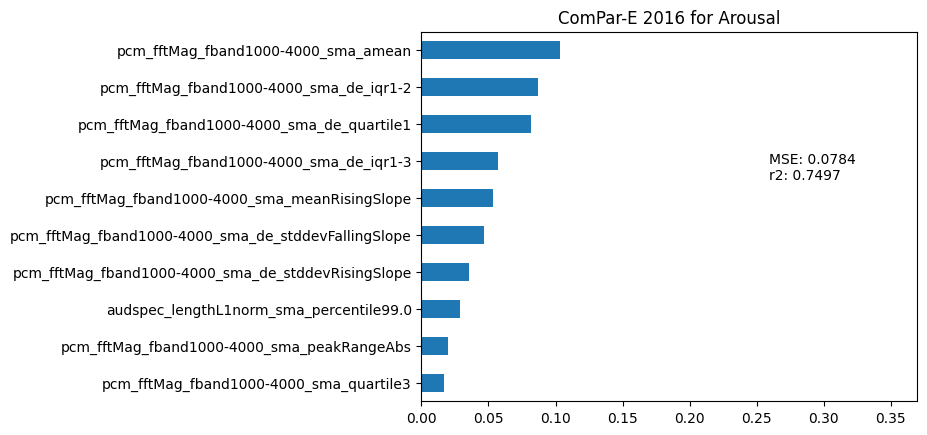

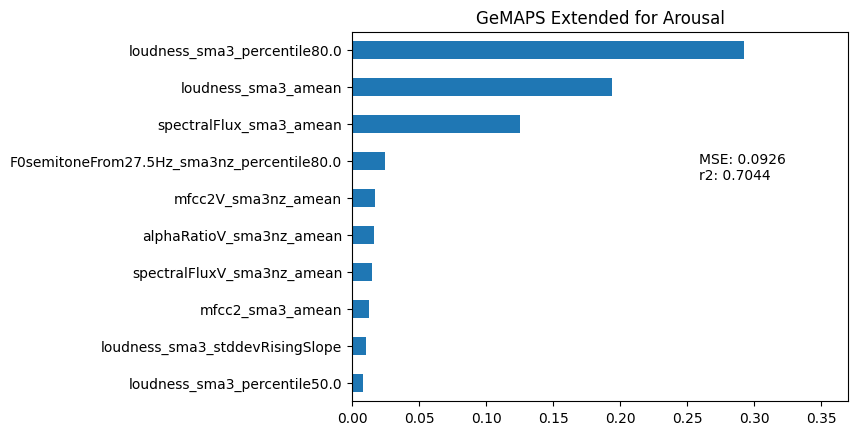

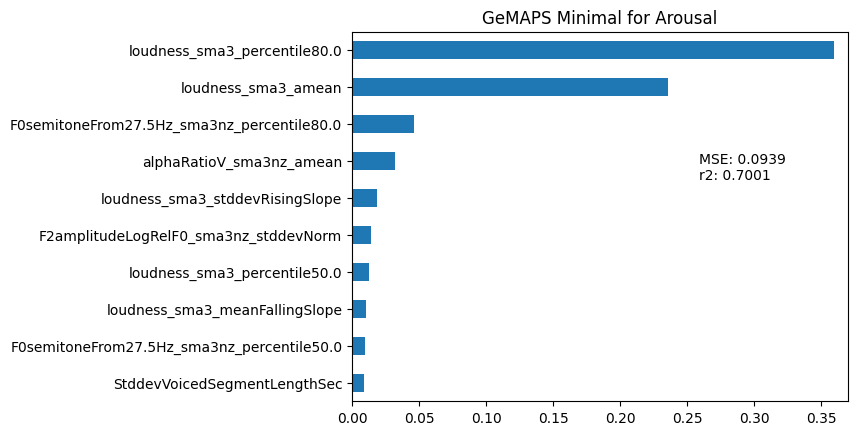

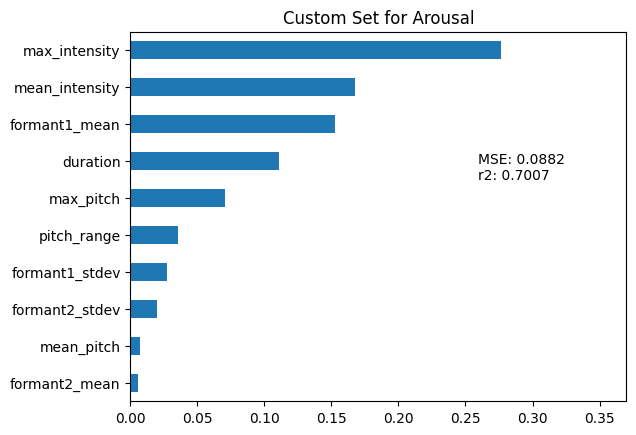

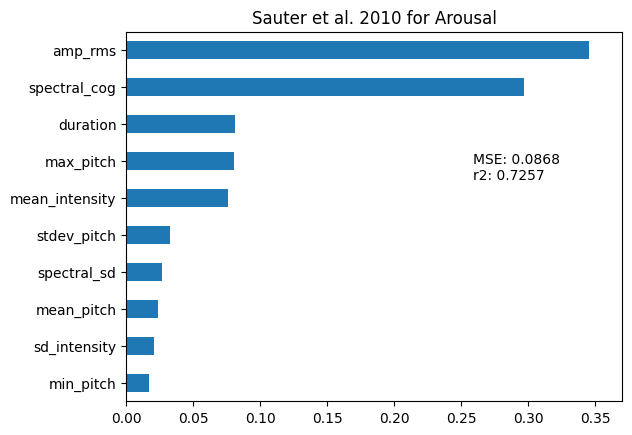

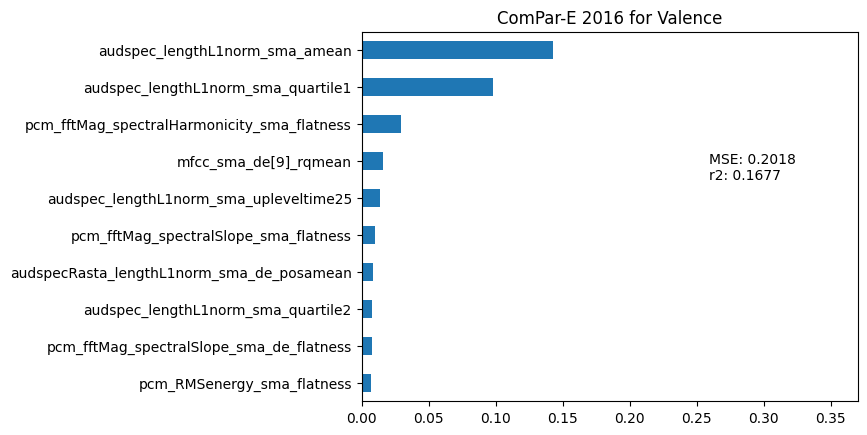

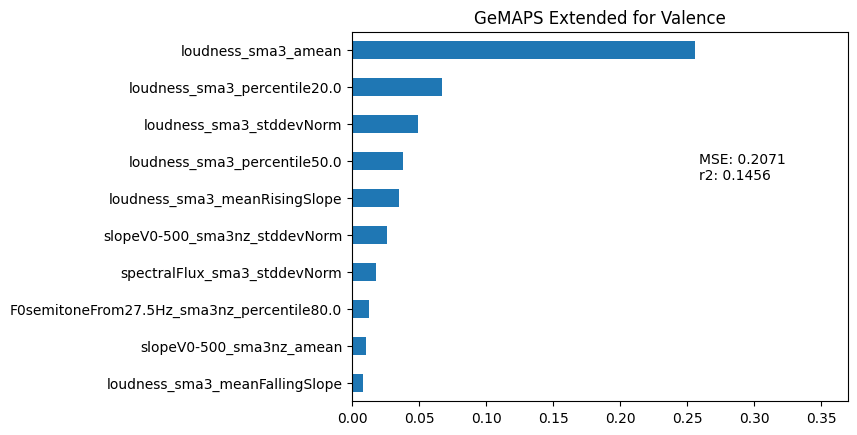

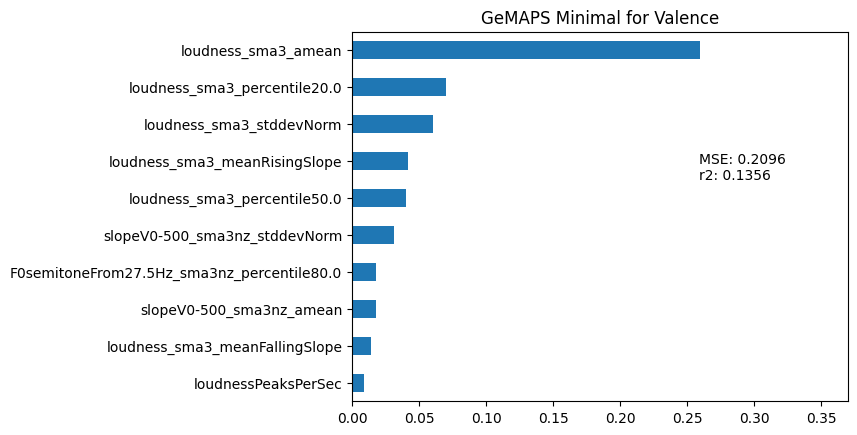

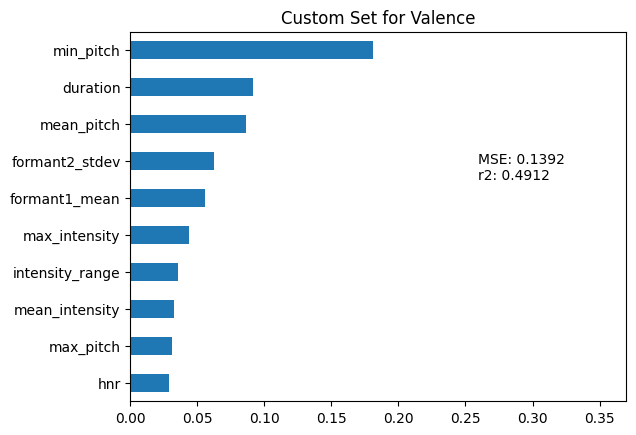

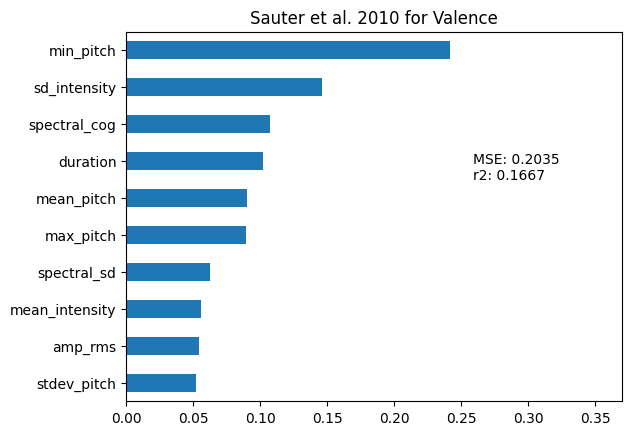

In [4]:
affects = ["mean_arousal", "mean_valence"]
affect_title = ["Arousal", "Valence"]
feature_sets = ['ComPar-E 2016', 'GeMAPS Extended', 'GeMAPS Minimal', 'Original Features', 'Sauter Features']
feature_titles = ['ComPar-E 2016', 'GeMAPS Extended', 'GeMAPS Minimal', 'Custom Set', 'Sauter et al. 2010']

show_plot = True
for i in range(len(affects)):
    for j in range(len(feature_sets)):
        df = all_rf_importances
        subset = df[(df['dimension']==affects[i]) & (df['dataset']==feature_sets[j])]
        subset_sorted = subset.sort_values(by="importance",  ascending=False)[:10][::-1]

        df = all_rf_results
        stats_subset = df[(df['dimension']==affects[i]) & (df['dataset']==feature_sets[j])].reset_index()
        # expl_var = round(stats_subset.at[0, "explained variance"], 4)
        mse = round(stats_subset.at[0,"MSE"], 4)
        r2score = round(stats_subset.at[0, "r2"], 4)
        plot_text = " ".join(["MSE:", str(mse), "\nr2:", str(r2score)]) # "\nVar Expl.:", str(expl_var),

        if show_plot:
            ax = subset_sorted.plot.barh(x='feature', y='importance', legend=False)        
            ax.set_title(feature_titles[j]+" for "+affect_title[i])
            ax.set_xlim(0, 0.37)
            ax.set_xlabel(None)
            ax.set_ylabel(None)
            ax.annotate(plot_text, xy=(0.7, 0.6), xycoords='axes fraction')
            plt.show()